# Image Segmentation using the EM algorithm

We are going to perform image segmentation on a given image input, using the EM algorithm. Our goal will be to maximize the following likelihood: $$p(x) = \sum_{k=1}^{K} π_k \prod_{d=1}^{D} \frac{1}{\sqrt{2πσ_k^2}}e^{\frac{1}{2σ_k^2}(x_d - μ_{kd})^{2}}$$

For simplification reasons, we will apply the $log$ function to the function above in order to get an easier to compute function: $$L(μ, σ^2, π) = \log{p(x)}=\sum_{k=1}^{K} \log{π_k} + (\sum_{d=1}^{D} -\log{\sqrt{2πσ_k^2}} - \frac{1}{2σ_k^2}(x_d - μ_{kd})^{2})$$

We will maximize on $μ, σ^2, π$.

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

### We are going to define functions that will help us when we execute EM. 
Before we do that let's clarrify the meaning of some of the parameters:

$X$ : An image of the following shape $(WxH)x3$, where 3 is the number of colors (RGB),  W is the width and H is the height. (it needs to be converted to 2D.)

$N=WxH$ : Number of pixels in X.

$K$: Number of clusters.

$D$: Number of colours (3).

$μ$: A matrix of shape KxD with the centers of the clusters.

$π$: The a priori distribution. A vector of K positions that contains the probabilities of a new pixel belonging to a cluster.

$σ^2$: The covariance matrix. In our case, we are going to simplify things and we are going to use a vector of K positions (and not a 2D matrix of shape KxD).

#### At first we are going to initialize some helper functions for our algorithm

In [2]:
def image_to_data(image_data):
    '''
    Convert 3D image to 2D. From WxHxD to (WxH)xD.
    :param image_data: The image you want to convert
    :return: The new 2D image
    '''
    height, width, D = image_data.shape
    N = height * width
    X = np.zeros((N, D))
    for w in range(width):
        for h in range(height):
            n = h + (w - 1) * height
            X[n, 0] = image_data[h, w, 0]
            X[n, 1] = image_data[h, w, 1]
            X[n, 2] = image_data[h, w, 2]

    return X

In [3]:
def data_to_image(X, height, width):
    '''
    Convert the NxD matrix to WxHxD where WxH = N
    :param X: The image you want to convert to 3D
    :param height: The height your image should have
    :param width: The wifth your image should have
    :return: The new image in 3 dimensions
    '''
    N, D = X.shape
    newImage = np.zeros((height, width, D))
    for n in range(1, N+1):
        w = np.fix(n/height)
        if n % height != 0:
            w = w + 1
        h = n - (w - 1) * height
        newImage[int(h)-1, int(w)-1, :] = X[n-1, :]

    return newImage

#### Now let's convert the image to 2D

In [4]:
path_to_image = '../images/img.jpg'

In [5]:
# Let's say we want to find 8 clusters in the image
K = 32

# Get the image as a N X D matrix.
start_img = Image.open(path_to_image, 'r')
img_array = np.array(start_img)
X = image_to_data(img_array)
# Normalize pixel values
X = X/np.max(X)
# X = X/255
# get image properties.
height, width, D = img_array.shape
height, width, D

(319, 484, 3)

#### Initialize EM parameters

At first, let's take a look at the __Complete Likelihood__. This would be:
$$p(X, Z|μ, σ^2, π) = \prod_{n=1}^{N} \prod_{k=1}^{K} [π_k \prod_{d=1}^{D} μ_{kd}^{X_{nd}} (1-μ_{kd})^{1-X_{nd}}]^{Z_{nk}}$$
where $z_{nk}$ is a hidden variable.

Secondly, we will apply the $log$ function in order to get the __Complete Log Likelihood__ : $L_C(μ, σ^2, π)$ (Do the math!)

Third, we will compute the __Expected Complete Log Likelihood__. Since each $Z_{nk}$ appears linearly in $L_C$ then we can approximate $Z_{nk}$ with the average of $L_C$ which we call $γ(z_{nk})$.

We are going to calculate $γ$ which will be a $NxK$ matrix that will show us if $X_n$ is likely to belong to cluster $K$. Since we have a mixture of Gaussian distributions, then:

$$γ(z_{nk}) = \frac{π_k N(X_n|μ_k, σ_k^2)}{\sum_ {j=1}^{K} π_j N(X_n|μ_j, σ_j^2)}$$

So, if we apply the $log$ function we have:

$$γ(z_{nk}) = \frac{e^{\sum_ {k=1}^{K} \log{π_k} - \sum_ {d=1}^{D} \log{\sqrt{2πσ_k^2}} + \frac{(x_d - μ_{kd})^{2}}{2σ_k^2}}} {\sum_ {j=1}^{K} π_j N(X_n|μ_j, σ_j^2)} $$

In [6]:
# Get matrix properties.
N, D = X.shape

# Initialize the probabilities of gamma(Ζnk) as a numpy array of shape NxK filled with zeroes.
gamma = np.zeros((N, K))

# Initialize p (1 X K vector). It keeps the prior probality of cluster k.
p = np.zeros(K)
p[:K] = 1/K

# Initialize the m, K X D vector.
# m_k is the centroid of cluster k.
# Initialize m, using K random points from X.
m = X[np.random.randint(X.shape[0], size=K), :]

# The initialization value of sigma is essential on how the algorithm performs so tune it to your needs.
sigma = (0.1 * np.var(X)) * np.ones(K)
m, sigma, p

(array([[0.        , 0.07058824, 0.08627451],
        [0.16470588, 0.46666667, 0.67843137],
        [0.09803922, 0.10196078, 0.08235294],
        [0.43921569, 0.32941176, 0.24313725],
        [0.00392157, 0.01960784, 0.02352941],
        [0.11372549, 0.16862745, 0.20392157],
        [0.09019608, 0.47843137, 0.73333333],
        [0.23529412, 0.49411765, 0.72941176],
        [0.05098039, 0.11372549, 0.07058824],
        [0.13333333, 0.15294118, 0.02745098],
        [0.00392157, 0.01176471, 0.        ],
        [0.11372549, 0.1254902 , 0.08235294],
        [0.12156863, 0.21568627, 0.0745098 ],
        [0.00392157, 0.35686275, 0.56078431],
        [0.14901961, 0.4627451 , 0.69411765],
        [0.07843137, 0.2       , 0.02745098],
        [0.        , 0.04705882, 0.        ],
        [0.21176471, 0.49019608, 0.70980392],
        [0.02745098, 0.10196078, 0.        ],
        [0.14901961, 0.22745098, 0.09019608],
        [0.16862745, 0.43921569, 0.6       ],
        [0.02745098, 0.46666667, 0

#### We must define some functions that will be used in the iterations.

At each iteration, we are going to perform an expectation and a maximization step. In the end we are going to calculate the likelihood in the given iteration. This will allow us to understand many things about out algorithm. There are 3 cases:

- __Likelihood has decreased__ : This means that we have run into an error. Likelihood should only be increasing in our algorithm (or stay the same).
- __Likelihood difference was below our tolerance value__: This means that between two iterations, the likelihoods are really close to each other, so we do not need to continue iterating. An advised tolerance value is below 1e-3.
- __Likelihood increased__: The algorithm needs more steps in order to converge.

In [7]:
def maximum_likelihood(X, m, K, sigma, p):
    """ This function is used in order to compute the maximum likelihood using numerical stable way.
    :param X: The 2D representation of the image.
    :param m: A vector of length K with the cluster centers.
    :param K: Number of clusters we want to find.
    :param sigma: The covariance matrix which is a vector of length K.
    :param p: The apriori distribution.
    :return : The maximum log likelihood for the given parameters.
    """
    N, D = X.shape
    lhood = np.zeros((N, K))
    for k in range(K):
        for d in range(D):
            lhood[:, k] = lhood[:, k] + np.log(np.sqrt(2*np.pi*sigma[k])) + (((X[:, d] - m[k, d])*(X[:, d] - m[k, d])) / (2*sigma[k]))

        lhood[:, k] = np.log(p[k]) - lhood[:, k]

    maxF = np.amax(lhood, axis=1)
    repMax = np.tile(maxF, (K, 1)).T
    lhood = np.exp(lhood - repMax)
    # Convert to log likelihood
    likelihood = np.sum(maxF + np.log(np.sum(lhood, axis=1)))

    return likelihood

In [8]:
# Compute the initial maximum likelihood.
likelihood = maximum_likelihood(X, m, K, sigma, p)
likelihood

317589.17815956543

### And that's it, we now have a starting point.

As you may know, EM consists of two steps: 
- __Expectation__ : Where we try to calculate the a posteriori distribution based on the given EM parameters.
- __Maximization__ : Where we are tuning the model parameters in order to maximize the likelihood. This step is the most important since it defines how our model will react. In order to get the new values for our parameters we will maximize the Expected Complete Log Likelihood we saw earlier. Since we have 3 parameters, then we will maximize the function for each one. The outcome is as such:
     1.  For $μ$ we will simply use an average in order to find which pixels belong to cluster $k$. Since we have $D=3$ colors then $μ$ will be calculated as such: $$μ_{kd} = \frac{\sum_ {n=1}^{N} γ(z_{nk})X_nd}{\sum_ {n=1}^{N} γ(z_{nk})}$$.
     2.  For $σ$ we only have K positions. That means that we will have to group the information about the color to just one cell (for each k value). The updated sigma values will be: $$σ_k^2 = \frac{1}{\sum_{n=1}^{N} γ_{nk}} \sum_ {n=1}^{N} \sum_ {d=1}^{D} γ_{nk}(X_n - μ_{kd})^2$$
     3.  At last, we need to update the apriori distribution for the next step. It can be easily proved that $π$ always has the same form, no matter the initial distribution (so if we have a mixture of Poisson distributions, the $π$ would be updated in the same way: $$π_k = \frac{\sum_ {n=1}^{N} γ(z_{nk})}{N}$$

In [9]:
# Define max number of iterations
EPOCHS = 30
# Define convergence tolerance
tol = 1e-4

In [10]:
# Loop until convergence, or if maximum iterations are reached.
for e in tqdm(range(EPOCHS)):
    ##################################### EXPECTATION STEP #####################################
    s = np.zeros((N, K))
    for k in range(K):
        for d in range(D):
            s[:, k] = s[:, k] + np.log(np.sqrt(2*np.pi)*sigma[k]) + (((X[:, d] - m[k, d])*(X[:, d] - m[k, d])) / (2*sigma[k]))
        s[:, k] = np.log(p[k]) - s[:, k]

    s = np.exp(s)
    # Update gamma
    gamma = np.divide(s, (np.tile(np.sum(s, axis=1), (K, 1))).T)

    ##################################### MAXIMIZATION STEP #####################################
    sum_of_gamma = np.sum(gamma, axis=0)
    sk = np.zeros(K)
    for k in range(K):

        for d in range(D):
            m[k, d] = np.divide(np.dot(gamma[:, k].T, X[:, d]), sum_of_gamma[k])  # Calculate mean_new of k, d

        # Update sigma for each k using the new m
        inside_of_sigma = np.sum(np.multiply(X-m[k, :], X-m[k, :]), axis=1)
        sk[k] = np.sum(gamma[:, k]*inside_of_sigma)
        denom = np.sum(gamma[:, k])
        sk[k] = sk[k]/(D*denom)

    p = sum_of_gamma / N
    sigma = sk
    # Keep only significant values
    # sigma[sigma < 1e-06] = 1e-06

    ##################################### CHECK FOR CONVERGENCE #####################################
    likelihoodNew = maximum_likelihood(X, m, K, sigma, p)
#     print(likelihoodNew)
#     if likelihoodNew < likelihood:
#         print('Likelihood is decreasing.')
#         break
#     else:
#         if (likelihoodNew - likelihood) < tol:
#             print('Convergence!\n')
#             break
#         else:
#             likelihood = likelihoodNew

# Assign each data point to its closer cluster
maxK = np.argmax(gamma, axis=1)  # Nx1 for each pixel
# Get the new image where each pixel has the value of its closest center
clusteredX = m[maxK, :]

100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


In [11]:
maxK.shape, gamma.shape

((154396,), (154396, 32))

In [12]:
def compute_error(X, clusteredX):
    '''
    Compute reconstruction error for image.
    :param X: The image data before being segmented.
    :param Xnew: The image data after being segmented.
    :return: The reconstruction error calculated
    '''
    error = (np.linalg.norm(X - clusteredX)**2) / X.shape[0]
    return error

In [13]:
# Compute the reconstruction error.
error = compute_error(X, clusteredX)

# Display the new clustered image
print(f'Clustered image with k = {K} \nReconstruction error: {error}')

Clustered image with k = 32 
Reconstruction error: 0.0025804554067753237


### Plot the segmented image. By only using 16 colors we have managed to make a good copy of our initial image.

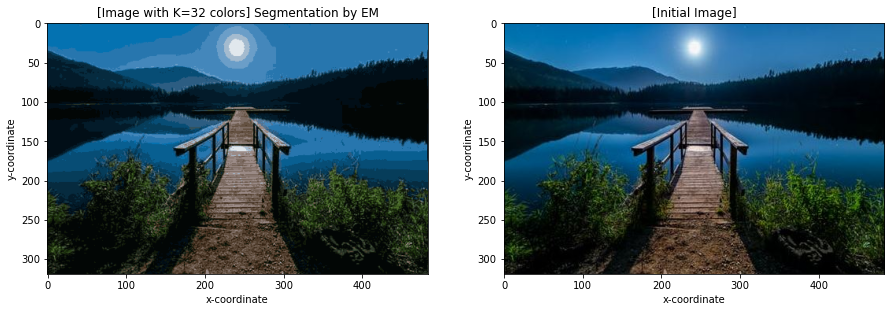

In [14]:
# Start plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
# Convert image to 3D
threed_img = data_to_image(clusteredX, height, width)
ax1.imshow(threed_img)
ax1.set_title('[Image with K={} colors] Segmentation by EM'.format(K))
# Set x-axis, y-axis
ax1.axes.set_xlabel('x-coordinate')
ax1.axes.set_ylabel('y-coordinate')

ax2.imshow(start_img)
ax2.set_title("[Initial Image]")
# Set x-axis, y-axis
ax2.axes.set_xlabel('x-coordinate')
ax2.axes.set_ylabel('y-coordinate')

plt.show()